# 线性回归
&emsp;&emsp;线性回归（linear regression）假设自变量$x$和因变量$y$之间的关系是线性的， 即***$y$可以表示为$x$中元素的加权和***，这里通常允许包含观测值的一些噪声； 其次，我们假设任何噪声都比较正常，如噪声遵循正态分布。

---
## 样本与训练集
一些概念解释
为了解释线性回归，我们举一个实际的例子： 我们希望根据房屋的面积（平方英尺）和房龄（年）来估算房屋价格（美元）。 为了开发一个能预测房价的模型，我们需要收集一个真实的数据集。 这个数据集包括了房屋的销售价格、面积和房龄。 在机器学习的术语中，该数据集称为训练数据集（training data set） 或**训练集（training set）**。 每行数据（比如一次房屋交易相对应的数据）称为**样本（sample）**， 也可以称为数据点（data point）或**数据样本（data instance）**。 我们把试图预测的目标（比如预测房屋价格）称为**标签（label）** 或目标（target）。 预测所依据的自变量（面积和房龄）称为**特征（feature）** 或协变量（covariate）。

通常，我们使用$n$来表示数据集中的样本数。 对索引为$i$的样本，其输入表示为$\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$， 其对应的标签是$y^{(i)}$。

---
## 线性回归问题的一般化表示
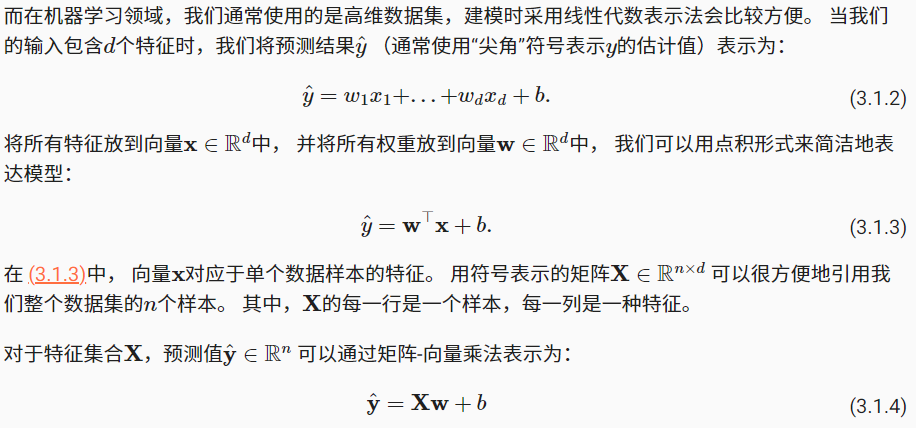

---
## 损失函数
cost function, 度量模型预测值与实际值的偏差，这里采用均方误差表示法(MSE)
$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
为了度量LRM在整个数据集上的误差，我们有
$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$
在训练模型时，我们希望寻找一组参数$\mathbf{w}^*, b^*$， 这组参数能最小化在所有训练样本上的总损失。如下式：
$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

---
## 随机梯度下降
为了使损失函数最小，这里采取 **梯度下降(Gradient Descent)** 算法，它是一个迭代类型的算法，基本思想是使参数($\omega, b$)沿着梯度减小的方向不断更新，它控制更新的方向(梯度减小的方向)以及每次更新的大小(step).

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值） 关于模型参数的导数（在这里也可以称为梯度）。 但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。 因此，我们**通常会在每次需要计算更新的时候随机抽取一小批样本**， 这种变体**叫做小批量随机梯度下降（minibatch stochastic gradient descent）**。
$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$
首先随机抽样一个小批量$\mathcal{B}$， 它是由固定数量的训练样本组成的。 然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。 最后，我们将梯度乘以一个预先确定的正数$\eta$，并从当前参数的值中减掉。

### 随机小批量梯度下降算法步骤
（1）初始化模型参数的值，如随机初始化； 
（2）从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。

### 算法参数解释
$|\mathcal{B}|$表示每个小批量中的样本数，这也称为**批量大小（batch size）**。 $\eta$表示学习率（learning rate）。 批量大小和学习率的值通常是手动预先指定，而不是通过模型训练得到的。 **这些可以调整但不在训练过程中更新的参数称为超参数（hyperparameter）**。 调参（hyperparameter tuning）是选择超参数的过程。 超参数通常是我们根据训练迭代结果来调整的， 而训练迭代结果是在独立的验证数据集（validation dataset）上评估得到的。

---


## 生成数据模拟线性回归
每一条数据包含2个特征，首先需要生成包含噪声的数据，假设1000条

`torch.mormal(mean, std, shape)`: 按照$(mean, std^2)$正态分布采样得到形状为shape的tensor

`torch.matmul`: Matrix product of two tensors.

In [1]:
import torch

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features[0], labels[0]

(tensor([-0.6028,  0.1698]), tensor([2.4091]))

## 小批量抽样函数
定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签

In [6]:
import random
def data_iter(batch_size, features, labels):
    """
    batch_size: 小批量的大小
    features: 特征矩阵, n行(表示有n个样本)d列(表示每个样本由d个特征描述)
    labels: 标签或者目标值, 连续值, nx1的列向量
    """
    num_examples = features.shape[0]
    indices = list(range(num_examples))
    random.shuffle(indices)  # 打乱下标值
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
# yield 是一种特殊状态的return, 表示函数是一个迭代器
# yield 把值传到调用者, 接着从返回点继续执行直到函数执行结束

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X.shape, y.shape)
    break;

torch.Size([10, 2]) torch.Size([10, 1])


初始化模型参数$\omega$和$b$, 建立模型$y=X\omega+b$

In [4]:
n = 1000
d = 2
w = torch.normal(0, 0.01, (d, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True) # 广播机制
features.shape, w.shape, b.shape

(torch.Size([1000, 2]), torch.Size([2, 1]), torch.Size([1]))

In [5]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

定义损失函数`squared_loss`

In [7]:
def squared_loss(y_hat, y):
    return (1/2)*(y.reshape(y_hat.shape)-y_hat)**2

定义损失目标优化函数（梯度下降算法）

In [8]:
def sgd(params, lr, batch_size):
    """Small batch random Gradient Descent"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

接下来可以开始进行训练了。理解这段代码至关重要，因为从事深度学习后， 你会一遍又一遍地看到几乎相同的训练过程。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。
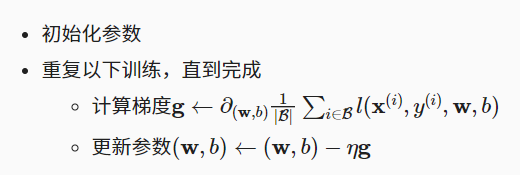

In [14]:
lr = 0.003
batch_size = 10
net = linreg
loss = squared_loss
num_epoches = 10 # 总体的训练次数
for epoch in range(num_epoches):
    for X, y in data_iter(batch_size, features, labels):
        batch_loss = loss(net(X, w, b), y) # 计算小批量样本的损失
        # batch_loss是一个(batch_size, 1)的向量
        # 先求和然后进行backward计算梯度
        batch_loss.sum().backward()
        # 更新参数
        sgd([w, b], lr, batch_size)
    # 以上便完成了一轮次的迭代更新
    with torch.no_grad():
        tl = loss(net(features, w, b), labels)
        print(f"epoch{epoch+1}, train loss is {float(tl.mean()):f}")

epoch1, train loss is 0.000104
epoch2, train loss is 0.000082
epoch3, train loss is 0.000069
epoch4, train loss is 0.000063
epoch5, train loss is 0.000059
epoch6, train loss is 0.000057
epoch7, train loss is 0.000056
epoch8, train loss is 0.000055
epoch9, train loss is 0.000055
epoch10, train loss is 0.000054


In [17]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')
w, b, w.shape, true_w.shape

w的估计误差: tensor([8.4400e-05, 1.7405e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


(tensor([[ 1.9999],
         [-3.4002]], requires_grad=True),
 tensor([4.1994], requires_grad=True),
 torch.Size([2, 1]),
 torch.Size([2]))